In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import tensorflow as tf

KeyboardInterrupt: 

In [2]:
def preprocess_mnist(image):
    # Garantir que a imagem seja uint8
    image_uint8 = image.astype(np.uint8)
       
    # Gaussian Blur para reduzir ruído
    image_blurred = cv2.GaussianBlur(image_uint8, (5, 5), 0)

    # Binarização usando Otsu
    _, image_binarized = cv2.threshold(image_blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Encontrar o contorno principal
    contours, _ = cv2.findContours(image_binarized, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        # Encontrar bounding box do maior contorno
        x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
        cropped = image_binarized[y:y+h, x:x+w]
        
        # Redimensionar o número para 20x20
        digit_resized = cv2.resize(cropped, (20, 20), interpolation=cv2.INTER_AREA)

        # Adicionar padding para ficar 28x28
        padded = cv2.copyMakeBorder(digit_resized, 4, 4, 4, 4, cv2.BORDER_CONSTANT, value=0)
    else:
        padded = np.zeros((28, 28), dtype=np.uint8)  # Caso não encontre contornos

    # Normalizar para [0, 1]
    image_normalized = padded / 255.0
    
    return image_normalized

In [40]:
def load_and_preprocess_mnist():
    # Load the MNIST dataset from OpenML
    mnist = fetch_openml('mnist_784', version=1, as_frame=False)
    x, y = mnist.data, mnist.target.astype(int)

    # # Normalize the data to [0, 1]
    # x = x / 255.0

    # Select 3000 samples for training and 1000 for testing
    x_train, y_train = x[:3000], y[:3000]
    x_test, y_test = x[3000:4000], y[3000:4000]

    # Reshape the images to 28x28
    x_train = x_train.reshape(-1, 28, 28, 1)
    x_test = x_test.reshape(-1, 28, 28, 1)
    
    x_train_processed = np.array([preprocess_mnist(image) for image in x_train])
    x_test_processed = np.array([preprocess_mnist(image) for image in x_test])
    
    return (x_train_processed, y_train), (x_test_processed, y_test)

# Chamada da função
try:
    (x_train, y_train), (x_test, y_test) = load_and_preprocess_mnist()

    # Verifica os formatos dos arrays
    print(f"Train set: {x_train.shape}, {y_train.shape}")
    print(f"Test set: {x_test.shape}, {y_test.shape}")

except Exception as e:
    print(f"Erro: {e}")


Train set: (3000, 28, 28), (3000,)
Test set: (1000, 28, 28), (1000,)


In [23]:
def train_and_evaluate_svm(x_train, y_train, x_test, y_test):
    model = SVC(C=10, gamma=0.001, kernel="rbf", probability=True)  # Enable probability predictions
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    return model

In [5]:
def save_model(model, path="svm_model2.joblib"):
    joblib.dump({"model": model}, path)
    print(f"Model exported to {path}")

# Load a saved model
def load_model(path="svm_model2.joblib"):
    data = joblib.load(path)
    print(f"Model loaded from {path}")
    return data["model"]

In [26]:
def save_plot(image, title, folder="images"):
    if not os.path.exists(folder):
        os.makedirs(folder)
    plt.figure(figsize=(2, 2))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.savefig(f"{folder}/{title}.png", bbox_inches='tight', pad_inches=0)
    plt.close()
    
def read_image(image_path):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    save_plot(image_rgb, "Original")
    return image_rgb

# Step 1: Grayscale Conversion
def convert_to_grayscale(image_rgb):
    grayscale_image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    save_plot(grayscale_image, "Grayscale")
    return grayscale_image

# Step 2: Noise Reduction using a Gaussian and Median Blur
def reduce_noise(grayscale_image):
    gaussian_blurred = cv2.GaussianBlur(grayscale_image, (3, 3), 0)
    denoised_image = cv2.medianBlur(gaussian_blurred, 3)
    save_plot(denoised_image, "Denoised")
    return denoised_image

# Step 3: Binarization
def binarize_image(denoised_image):
    _, binarized_image = cv2.threshold(denoised_image, 127, 255, cv2.THRESH_BINARY)
    save_plot(binarized_image, "Binarized")
    return binarized_image

# Step 4: Color Inversion
def invert_colors(binarized_image):
    inverted_image = cv2.bitwise_not(binarized_image)
    save_plot(inverted_image, "Inverted")
    return inverted_image

# Step 5: Resize
def resize_image(inverted_image):
    contours, _ = cv2.findContours(inverted_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        x, y, w, h = cv2.boundingRect(max(contours, key=cv2.contourArea))
        cropped = inverted_image[y:y+h, x:x+w]
        digit_resized = cv2.resize(cropped, (20, 20), interpolation=cv2.INTER_AREA)
        resized_image = cv2.copyMakeBorder(digit_resized, 4, 4, 4, 4, cv2.BORDER_CONSTANT, value=0)
    else:
        resized_image = np.zeros((28, 28), dtype=np.uint8)
    save_plot(resized_image, "Resized (28x28)")
    return resized_image

# Step 6: Normalize Pixels
def normalize_pixels(resized_image):
    normalized_pixels = resized_image / 255.0
    save_plot(normalized_pixels, "Normalized")
    return normalized_pixels

# Step 6: Enhance thickness
def enhance_thickness(normalized_pixels):
    kernel = np.ones((3, 3), np.uint8)
    thickened_image = cv2.dilate(normalized_pixels, kernel, iterations=1)
    save_plot(thickened_image, "Thickened")
    return thickened_image

# Step 7: Standardize Pixels
def standardize_pixels(thickened_image, scaler_mean, scaler_scale):
    flattened = thickened_image.flatten()
    standardized_pixels = (flattened - scaler_mean) / scaler_scale
    standardized_pixels_reshaped = standardized_pixels.reshape(28, 28)
    save_plot(standardized_pixels_reshaped, "Standardized")
    return standardized_pixels

In [22]:
def preprocess_image(image_path, scaler_mean=np.zeros(28*28), scaler_scale=np.ones(28*28)):
    image_rgb = read_image(image_path)
    grayscale_image = convert_to_grayscale(image_rgb)
    denoised_image = reduce_noise(grayscale_image)
    binarized_image = binarize_image(denoised_image)
    inverted_image = invert_colors(binarized_image)
    resized_image = resize_image(inverted_image)
    normalized_pixels = normalize_pixels(resized_image)
    thickened_image = enhance_thickness(normalized_pixels)
    standardized_pixels = standardize_pixels(thickened_image, scaler_mean, scaler_scale)
    return standardized_pixels

def process_and_predict_images(folder_path, model):
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not image_files:
        print("No images found in the provided folder.")
        return

    for image_file in image_files:
        image_path = os.path.join(folder_path, image_file)
        try:
            image_normalized = preprocess_image(image_path)
            image_flattened = image_normalized.reshape(1, -1)  # Flatten the standardized image
            prediction = model.predict(image_flattened)[0]

            plt.figure(figsize=(2, 2))
            plt.imshow(image_normalized.reshape(28, 28), cmap='gray')
            plt.title(f"Predicted: {prediction}")
            plt.savefig(f"{"Predicted"}.png", bbox_inches='tight', pad_inches=0)
            plt.axis('off')
            plt.show()
        except Exception as e:
            print(f"Error processing {image_file}: {e}")


In [16]:
(x_train, y_train), (x_test, y_test) = load_and_preprocess_mnist()

x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

print("Train size: ",np.shape(x_train)[0])
print("Test size: ",np.shape(x_test)[0])

# x_train_pca, x_test_pca, pca = apply_pca(x_train, x_test)
model = train_and_evaluate_svm(x_train, y_train, x_test, y_test)

save_model(model)

NameError: name 'load_and_preprocess_mnist' is not defined

Model loaded from svm_model2.joblib


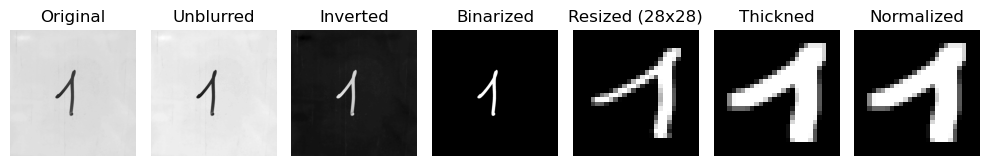

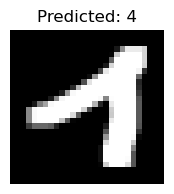

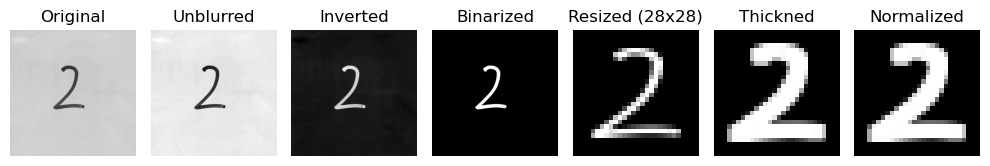

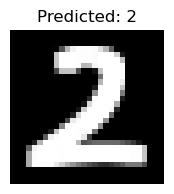

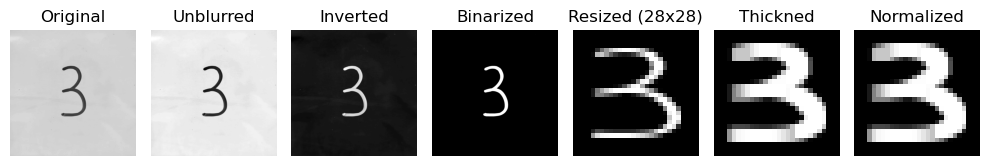

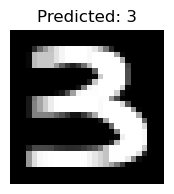

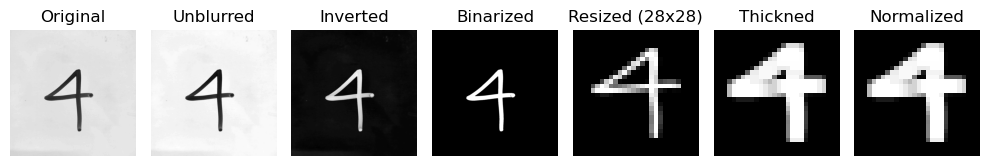

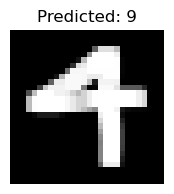

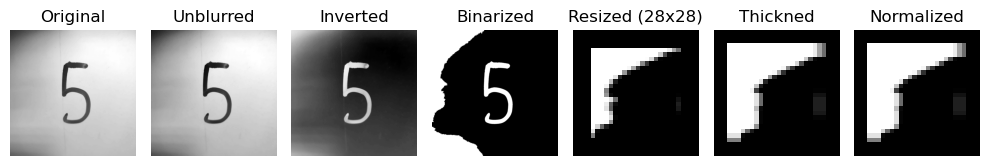

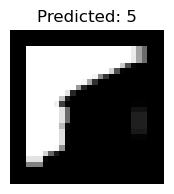

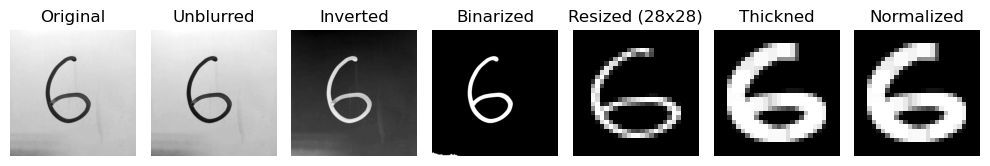

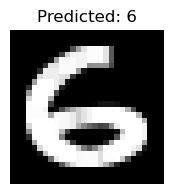

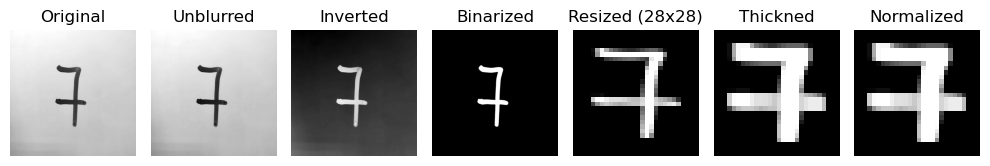

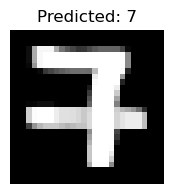

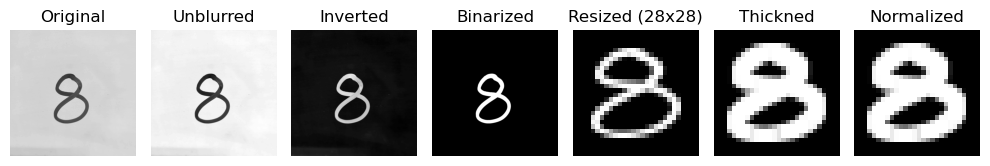

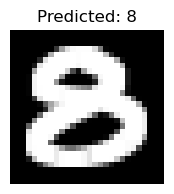

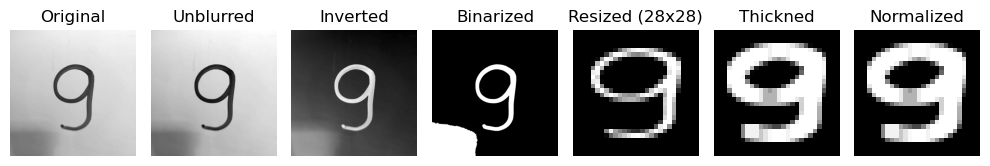

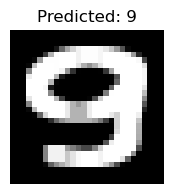

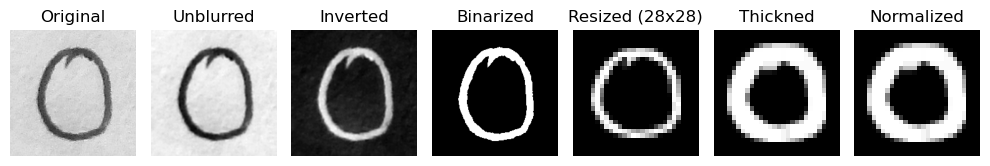

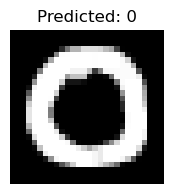

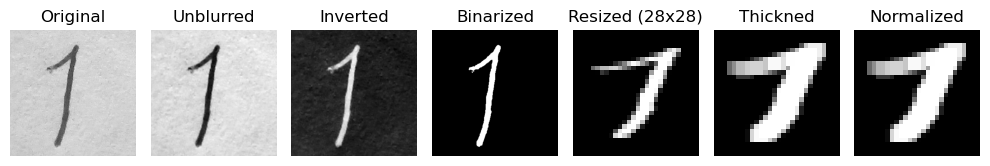

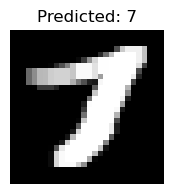

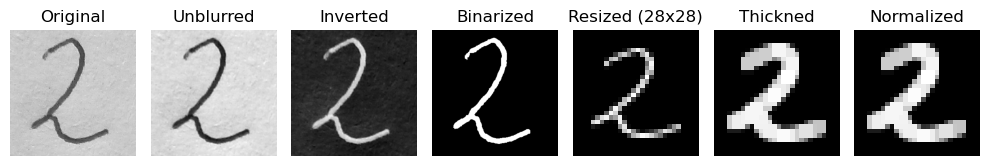

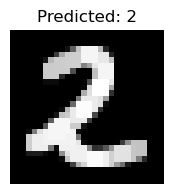

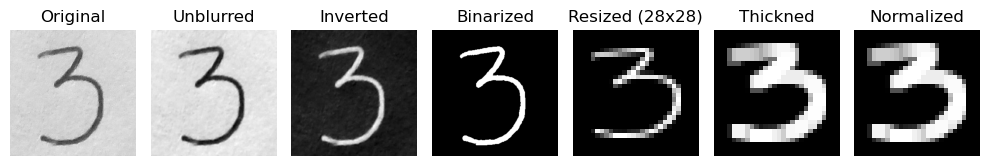

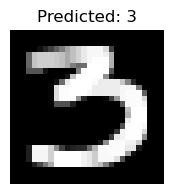

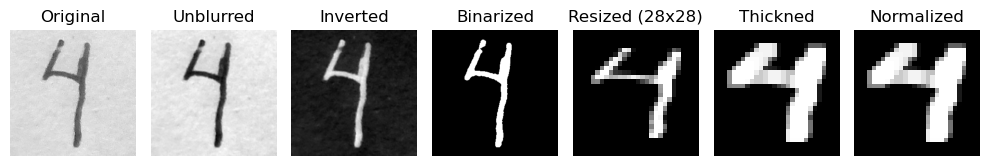

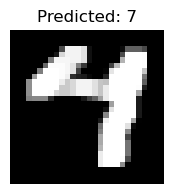

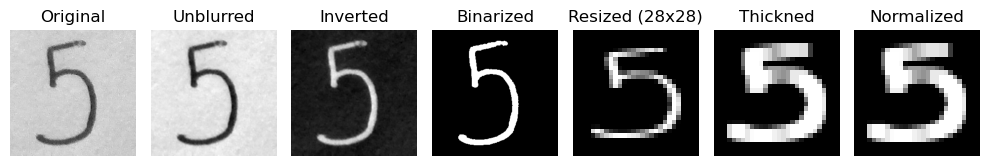

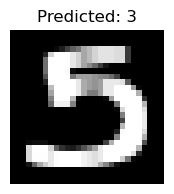

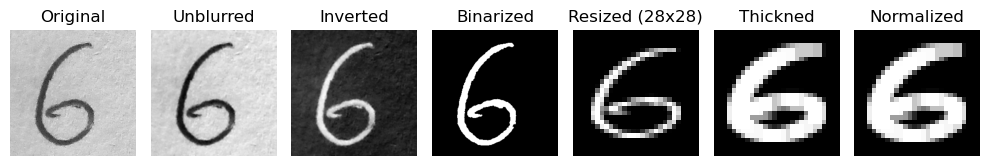

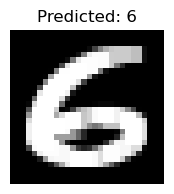

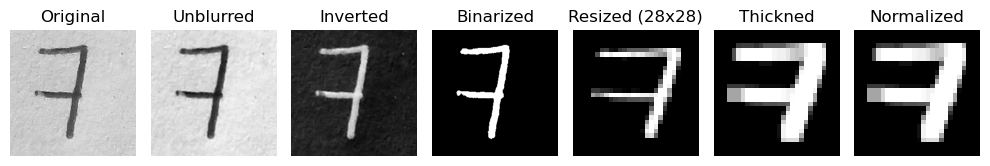

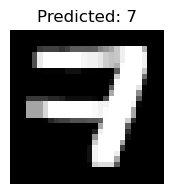

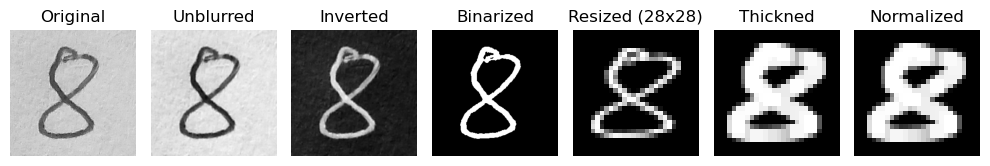

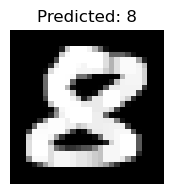

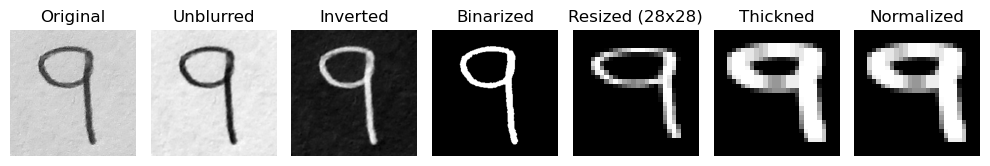

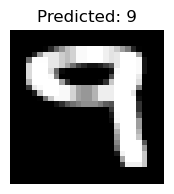

In [27]:
# Convert and save as TensorFlow Lite model
# tf_func = convert_svm_to_tf(model, input_shape=(None, x_train.shape[1]))
# save_tflite_model(tf_func)

model = load_model() ##

folder_path = "Images"  # Replace with your folder path
process_and_predict_images(folder_path, model)

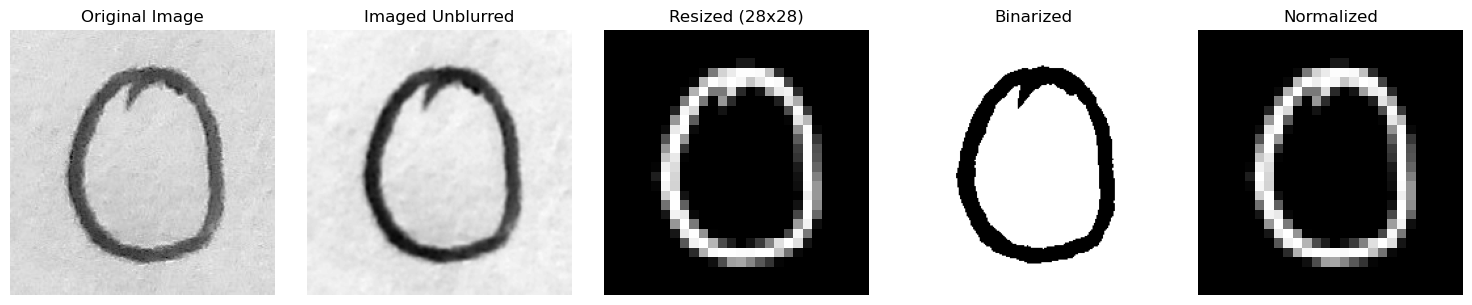

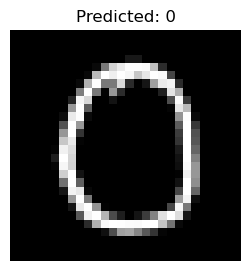

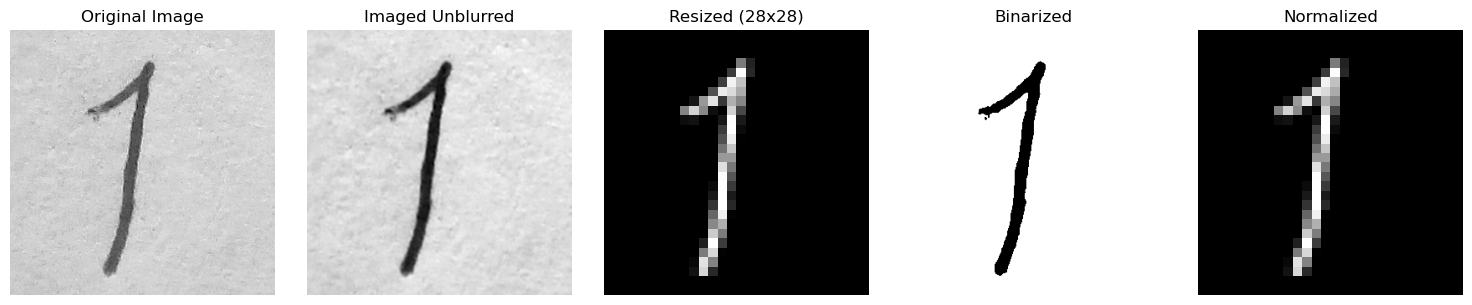

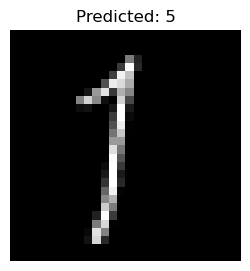

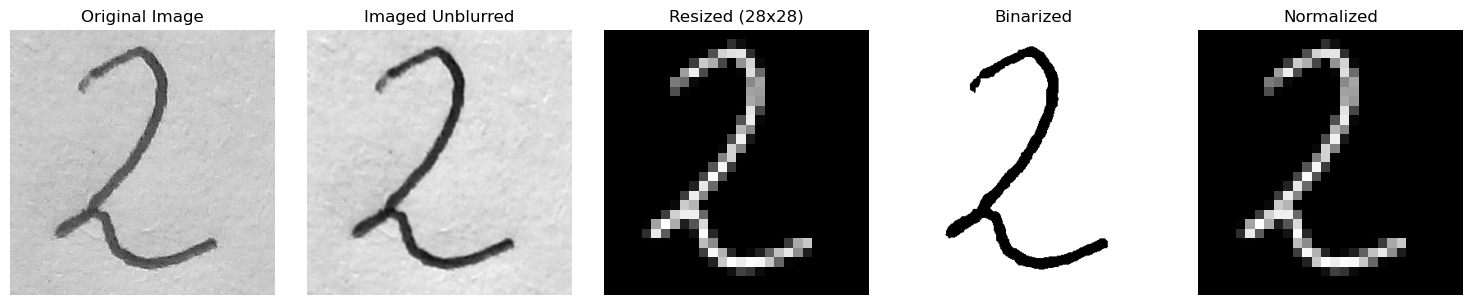

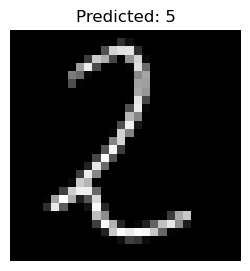

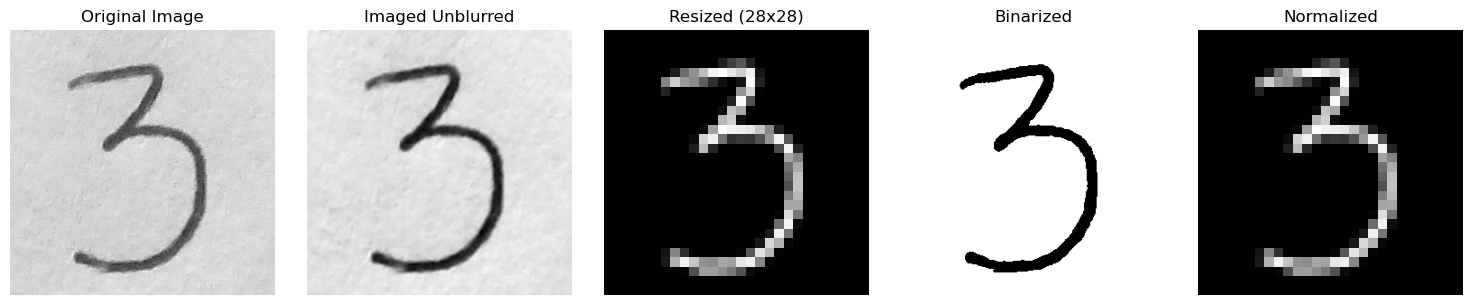

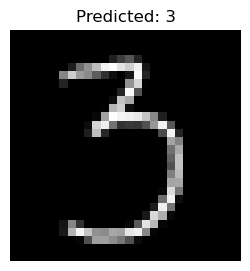

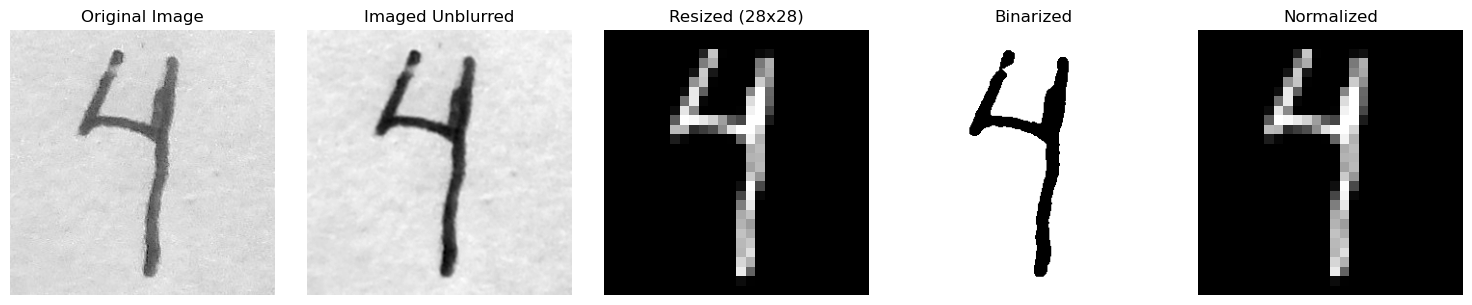

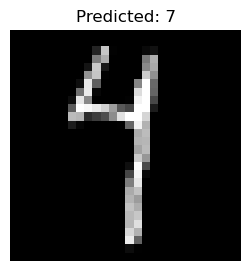

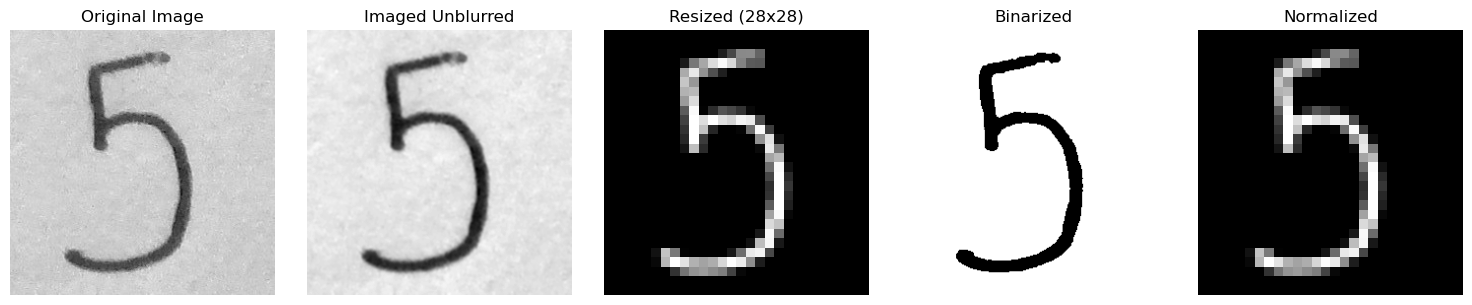

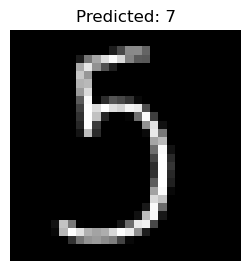

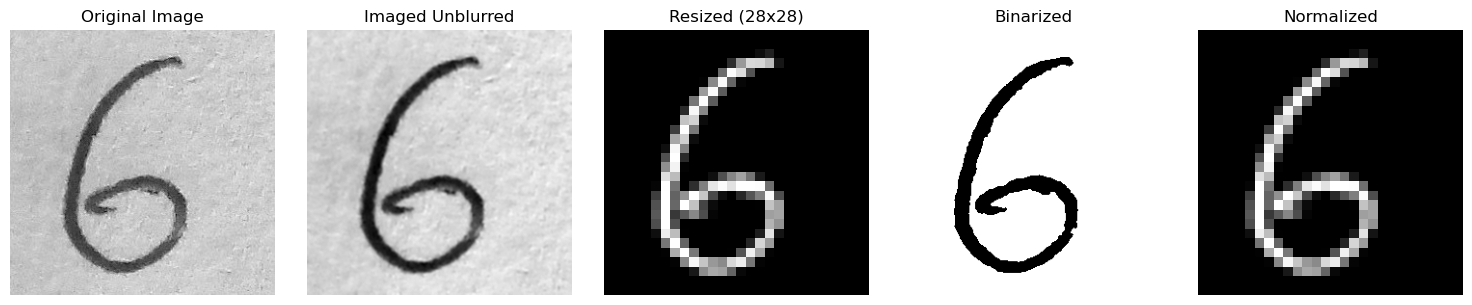

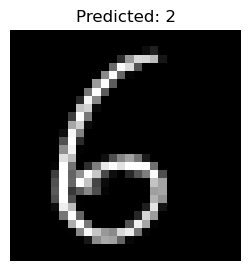

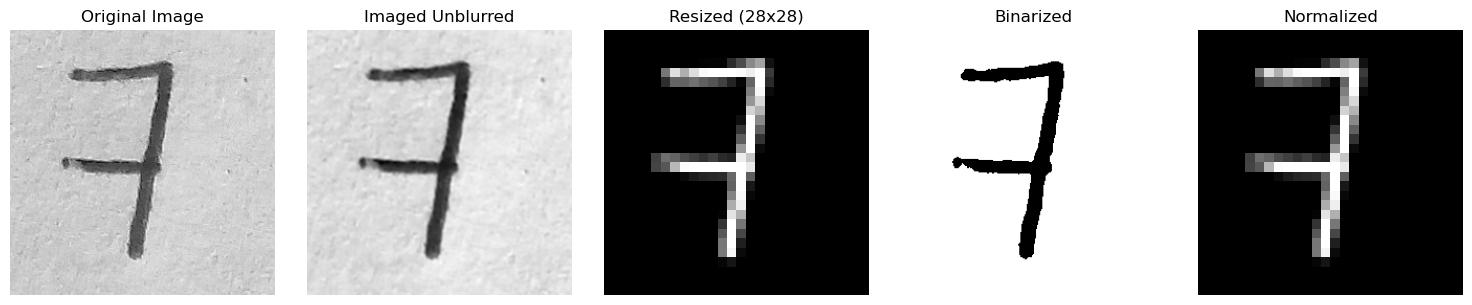

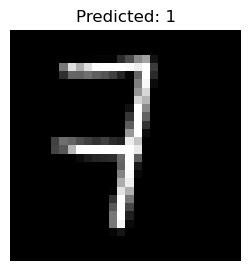

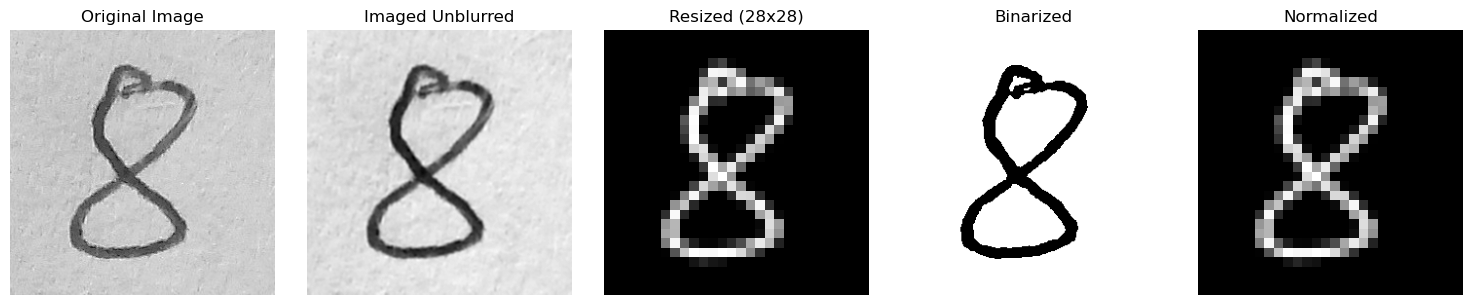

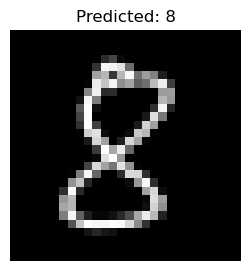

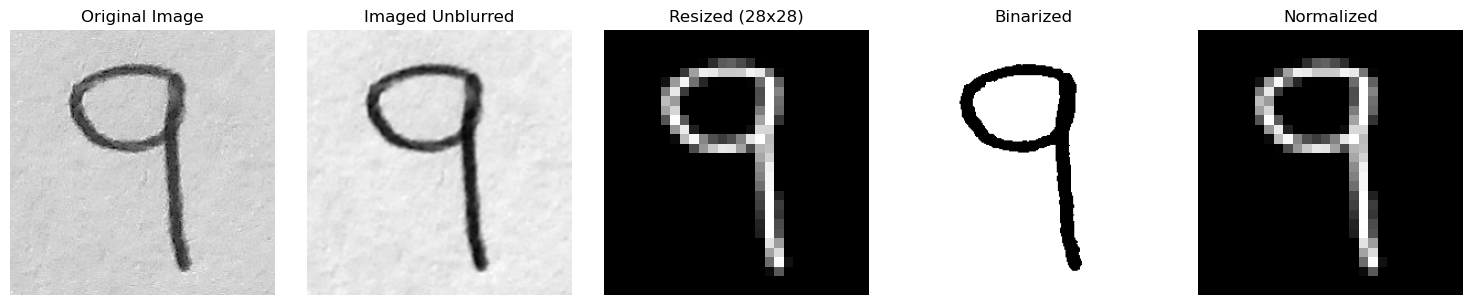

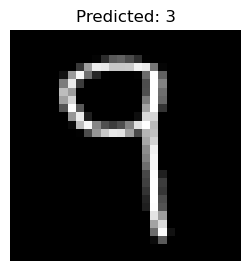

In [14]:
folder_path = "Images"  # Replace with your folder path
process_and_predict_images(folder_path, model)

Etiquete:  3
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.       

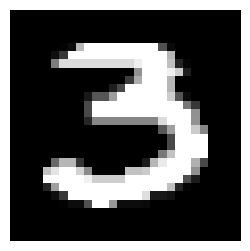

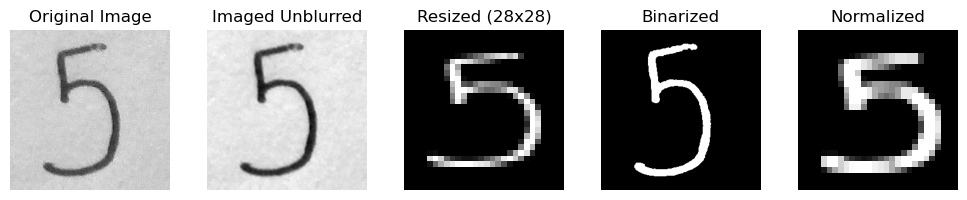

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.   

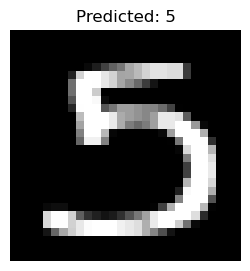

In [45]:
img_train = x_train[50].reshape((28,28))/ 255.0
print("Etiquete: ",y_train[50])
print(x_train[50])

plt.figure(figsize=(3, 3))
plt.imshow(img_train, cmap='gray')
plt.axis('off')
plt.show()

# img_real = cv2.imread("Images/num_5.jpg", cv2.IMREAD_GRAYSCALE)
img_real = "Images/num_5.jpg"
image_normalized = preprocess_image(img_real)
image_flattened = image_normalized.flatten().reshape(1, -1)
prediction = model.predict(image_flattened)[0]
print(image_flattened)

plt.figure(figsize=(3, 3))
plt.imshow(image_normalized, cmap='gray')
plt.title(f"Predicted: {prediction}")
plt.axis('off')
plt.show()

# prediction = model.predict(image_pca)[0]